In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
%run categories.py

In [3]:
df = pd.read_csv('../data_processing/cleaned-data.csv', index_col=0)

y = df.G3.values
X = df.drop(['G1', 'G2', 'G3', 'improved', 'passed'], axis=1).values

print(X.shape, y.shape)

(357, 30) (357,)


In [4]:
y2 = df.passed.values
y2.reshape(-1, 1)

print(y2[0:5])

[0 0 1 1 1]


In [5]:
# Setup the pipeline steps: steps
steps = [('ohe', OneHotEncoder(categories=categories)),
         ('adab', AdaBoostClassifier(base_estimator=None, algorithm='SAMME.R', random_state=0))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'adab__learning_rate': np.arange(0.09, 0.1, 0.001),
             'adab__n_estimators': np.arange(500, 1000, 100)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.3, random_state=0)

# Create the GridSearchCV object: yeg_cv
ada_pass_predict_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', cv=5, iid=False)

# Fit to the training set
ada_pass_predict_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe', OneHotEncoder(categorical_features=None,
       categories=[array(['GP', 'MS'], dtype=object), array(['F', 'M'], dtype=object), array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29], dtype=object), array(['R', 'U'], dtype=object), array(['GT3', ...ithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=0))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'adab__learning_rate': array([0.09 , 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098,
       0.099, 0.1  ]), 'adab__n_estimators': array([500, 600, 700, 800, 900])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [6]:
# Compute and print the metrics
auc = ada_pass_predict_cv.score(X_test, y_test)
print("Tuned adaBoost estimators: {}".format(ada_pass_predict_cv.best_params_))
print("Tuned adaBoost Area Under the Curve: {}".format(auc))

Tuned adaBoost estimators: {'adab__learning_rate': 0.094, 'adab__n_estimators': 600}
Tuned adaBoost Area Under the Curve: 0.47402880838061984


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

x_axis = ada_pass_predict_cv.predict_proba(X_test)
y_axis = y_test

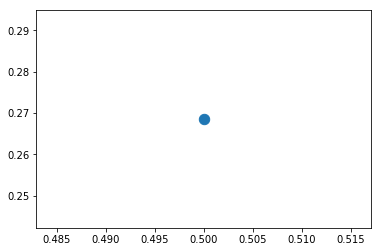

In [8]:
data = {'predicted_prob': x_axis[:, 0], 'actual': y_axis == False}
df_compare = pd.DataFrame(data)

df_grouped = df_compare.groupby(df_compare.predicted_prob.round(1)).agg({'actual':['mean', 'count']})
plt.scatter(df_grouped.index, df_grouped[('actual', 'mean')], s=df_grouped[('actual', 'count')])

# Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
# Setup the pipeline steps: steps
steps = [('ohe', OneHotEncoder(categories=categories)),
         ('rfc', RandomForestClassifier(max_depth=20))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfc__n_estimators': np.arange(500, 1000, 100)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.3, random_state=0)

# Create the GridSearchCV object: yeg_cv
rfc_pass_predict_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', cv=5, iid=False)

# Fit to the training set
rfc_pass_predict_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('ohe', OneHotEncoder(categorical_features=None,
       categories=[array(['GP', 'MS'], dtype=object), array(['F', 'M'], dtype=object), array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29], dtype=object), array(['R', 'U'], dtype=object), array(['GT3', ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'rfc__n_estimators': array([500, 600, 700, 800, 900])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [11]:
# Compute and print the metrics
auc = rfc_pass_predict_cv.score(X_test, y_test)
print("Tuned Random Forest estimators: {}".format(rfc_pass_predict_cv.best_params_))
print("Tuned Random Forest Area Under the Curve: {}".format(auc))

Tuned Random Forest estimators: {'rfc__n_estimators': 500}
Tuned Random Forest Area Under the Curve: 0.6414229594063727


In [12]:
feat_import = rfc_pass_predict_cv.best_estimator_.named_steps.rfc.feature_importances_
feat_columns = rfc_pass_predict_cv.best_estimator_.named_steps.ohe.get_feature_names()
feat_zip = zip(feat_import, feat_columns)
feat_list = list(feat_zip)
feat_list.sort(reverse=True)
print('Top Five Feature Importances:\n\n', 
      feat_list[:5], 
      '\n\n\n')
print('Encoded Variable Reference (x14_0 = first category of enumerated column 14 [failures] below):\n\n', 
      dict(enumerate(df.drop(['G1', 'G2', 'G3', 'improved', 'passed'], axis=1).columns)))

Top Five Feature Importances:

 [(0.028190187578707282, 'x14_0'), (0.026723645620705606, 'x14_2'), (0.014101061665034883, 'x28_3'), (0.013827912458382188, 'x25_2'), (0.013794510869000243, 'x28_5')] 



Encoded Variable Reference (x14_0 = first category of enumerated column 14 [failures] below):

 {0: 'school', 1: 'sex', 2: 'age', 3: 'address', 4: 'famsize', 5: 'Pstatus', 6: 'Medu', 7: 'Fedu', 8: 'Mjob', 9: 'Fjob', 10: 'reason', 11: 'guardian', 12: 'traveltime', 13: 'studytime', 14: 'failures', 15: 'schoolsup', 16: 'famsup', 17: 'paid', 18: 'activities', 19: 'nursery', 20: 'higher', 21: 'internet', 22: 'romantic', 23: 'famrel', 24: 'freetime', 25: 'goout', 26: 'Dalc', 27: 'Walc', 28: 'health', 29: 'absences'}


In [13]:
x_axis = rfc_pass_predict_cv.predict_proba(X_test)
y_axis = y_test

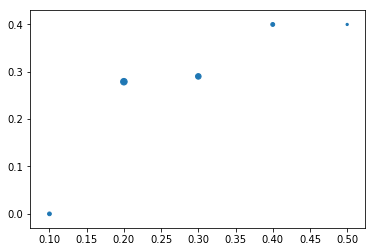

In [14]:
data = {'predicted_prob': x_axis[:, 0], 'actual': y_axis == False}
df_compare_2 = pd.DataFrame(data)

df_grouped = df_compare_2.groupby(df_compare_2.predicted_prob.round(1)).agg({'actual':['mean', 'count']})
plt.scatter(df_grouped.index, df_grouped[('actual', 'mean')], s=df_grouped[('actual', 'count')])

# Logistic Regression Model

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
# Setup the pipeline steps: steps
steps = [('ohe', OneHotEncoder(categories=categories)),
         ('logit', LogisticRegression(penalty='l2', solver='lbfgs', multi_class='auto'))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'logit__C': np.arange(0.1, 2, 0.05),
             'logit__tol': np.arange(0.00005, 0.001, 0.0001)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.3, random_state=0)

# Create the GridSearchCV object: yeg_cv
pass_predict_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', cv=10, iid=False)

# Fit to the training set
pass_predict_cv.fit(X_train, y_train)

# Compute and print the metrics
auc = pass_predict_cv.score(X_test, y_test)
print("Tuned Logistic Regression estimators: {}".format(pass_predict_cv.best_params_))
print("Tuned Logistic Regression Area Under the Curve: {}".format(auc))

Tuned Logistic Regression estimators: {'logit__C': 0.30000000000000004, 'logit__tol': 5e-05}
Tuned Logistic Regression Area Under the Curve: 0.6473155827149717


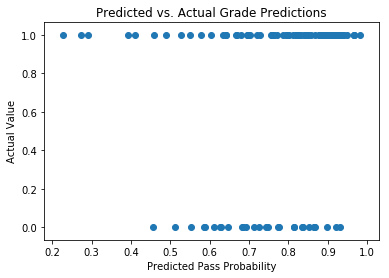

In [17]:
x_axis = pass_predict_cv.predict_proba(X_test)
y_axis = y_test

plt.scatter(x_axis[:, 1], y_axis)
plt.xlabel('Predicted Pass Probability')
plt.ylabel('Actual Value')
plt.title('Predicted vs. Actual Grade Predictions')

plt.show()

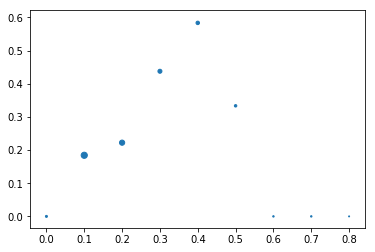

In [18]:
data = {'predicted_prob': x_axis[:, 0], 'actual': y_axis == False}
df_compare_3 = pd.DataFrame(data)

df_grouped = df_compare_3.groupby(df_compare_3.predicted_prob.round(1)).agg({'actual':['mean', 'count']})
plt.scatter(df_grouped.index, df_grouped[('actual', 'mean')], s=df_grouped[('actual', 'count')])

In [19]:
df_grouped[('actual', 'count')]

predicted_prob
0.0     4
0.1    38
0.2    27
0.3    16
0.4    12
0.5     6
0.6     2
0.7     2
0.8     1
Name: (actual, count), dtype: int64

In [20]:
feat_logit = pass_predict_cv.best_estimator_.named_steps.logit.coef_
feat_odds = np.exp(feat_logit[0])
feat_columns = pass_predict_cv.best_estimator_.named_steps.ohe.get_feature_names()
feat_zip = zip(feat_odds, feat_columns)
feat_list = list(feat_zip)
feat_list.sort(reverse=True)
print('Top Five Feature Odds:\n\n', 
      feat_list[:5], 
      '\n\n\n')
print('Encoded Variable Reference (x14_0 = first category of enumerated column 14 [failures] below):\n\n', 
      dict(enumerate(df.drop(['G1', 'G2', 'G3', 'improved', 'passed'], axis=1).columns)))

Top Five Feature Odds:

 [(2.122681917845231, 'x14_0'), (1.7169269786188874, 'x29_2'), (1.666072209283492, 'x25_2'), (1.538531459502563, 'x14_1'), (1.5376865407545497, 'x28_1')] 



Encoded Variable Reference (x14_0 = first category of enumerated column 14 [failures] below):

 {0: 'school', 1: 'sex', 2: 'age', 3: 'address', 4: 'famsize', 5: 'Pstatus', 6: 'Medu', 7: 'Fedu', 8: 'Mjob', 9: 'Fjob', 10: 'reason', 11: 'guardian', 12: 'traveltime', 13: 'studytime', 14: 'failures', 15: 'schoolsup', 16: 'famsup', 17: 'paid', 18: 'activities', 19: 'nursery', 20: 'higher', 21: 'internet', 22: 'romantic', 23: 'famrel', 24: 'freetime', 25: 'goout', 26: 'Dalc', 27: 'Walc', 28: 'health', 29: 'absences'}


# Random Forest Regressor

In [21]:
# Setup the pipeline steps: steps
steps = [('ohe', OneHotEncoder(categories=categories)),
         ('rfr', RandomForestRegressor(max_depth=20, criterion='mse'))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfr__n_estimators': np.arange(100, 300, 10)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Create the GridSearchCV object: yeg_cv
reg_predict_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_mean_squared_error', cv=10, iid=False)

# Fit to the training set
reg_predict_cv.fit(X_train, y_train)

# Compute and print the metrics
mse = reg_predict_cv.score(X_test, y_test)
print("Tuned RandomForest estimators: {}".format(reg_predict_cv.best_params_))
print("Tuned RandomForest mean squared error: {}".format(mse))
print(np.sqrt(abs(mse)))

Tuned RandomForest estimators: {'rfr__n_estimators': 220}
Tuned RandomForest mean squared error: -9.471320675458074
3.0775510841346034


In [22]:
x_axis = reg_predict_cv.predict(X_test)
y_axis = y_test

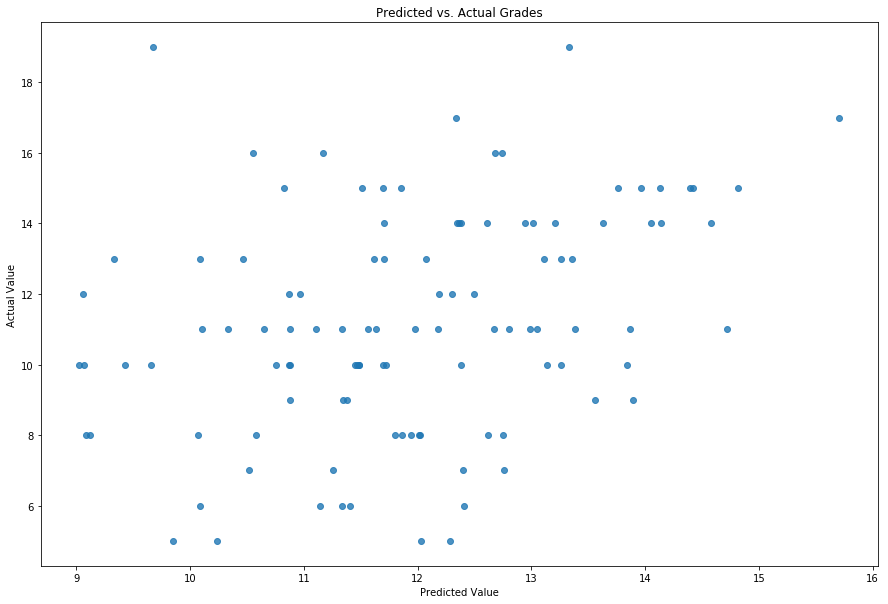

In [23]:
fig = plt.figure(figsize=(15,10))
plt.scatter(x_axis, y_axis, alpha=0.8)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Predicted vs. Actual Grades')
plt.show()

In [24]:
feat_import = reg_predict_cv.best_estimator_.named_steps.rfr.feature_importances_
feat_columns = reg_predict_cv.best_estimator_.named_steps.ohe.get_feature_names()
feat_zip = zip(feat_import, feat_columns)
feat_list = list(feat_zip)
feat_list.sort(reverse=True)
print('Top Five Feature Importances:\n\n', 
      feat_list[:5], 
      '\n\n\n')
print('Encoded Variable Reference (x14_0 = first category of enumerated column 14 [failures] below):\n\n', 
      dict(enumerate(df.drop(['G1', 'G2', 'G3', 'improved', 'passed'], axis=1).columns)))

Top Five Feature Importances:

 [(0.07378369096080405, 'x14_0'), (0.04085985348779895, 'x9_teacher'), (0.03157479739037813, 'x27_1'), (0.025027583674848957, 'x28_1'), (0.02065445163394839, 'x8_health')] 



Encoded Variable Reference (x14_0 = first category of enumerated column 14 [failures] below):

 {0: 'school', 1: 'sex', 2: 'age', 3: 'address', 4: 'famsize', 5: 'Pstatus', 6: 'Medu', 7: 'Fedu', 8: 'Mjob', 9: 'Fjob', 10: 'reason', 11: 'guardian', 12: 'traveltime', 13: 'studytime', 14: 'failures', 15: 'schoolsup', 16: 'famsup', 17: 'paid', 18: 'activities', 19: 'nursery', 20: 'higher', 21: 'internet', 22: 'romantic', 23: 'famrel', 24: 'freetime', 25: 'goout', 26: 'Dalc', 27: 'Walc', 28: 'health', 29: 'absences'}


In [25]:
X3 = df.drop(['G2', 'G3', 'passed', 'improved'], axis=1).values
y = df.G3.values
print(X.shape, y.shape)

(357, 30) (357,)


In [26]:
# Setup the pipeline steps: steps
steps = [('ohe', OneHotEncoder(categories=categories3)),
         ('rfr', RandomForestRegressor(max_depth=20, criterion='mse'))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfr__n_estimators': np.arange(150, 250, 10)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.3, random_state=0)

# Create the GridSearchCV object: yeg_cv
first_predict_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_mean_squared_error', cv=10, iid=False)

# Fit to the training set
first_predict_cv.fit(X_train, y_train)

# Compute and print the metrics
mse = first_predict_cv.score(X_test, y_test)
print("Tuned RandomForest estimators: {}".format(first_predict_cv.best_params_))
print("Tuned RandomForest mean squared error: {}".format(mse))
print(np.sqrt(abs(mse)))

Tuned RandomForest estimators: {'rfr__n_estimators': 160}
Tuned RandomForest mean squared error: -2.5001096570146952
1.58117350629673


In [27]:
x1_axis = first_predict_cv.predict(X_test)
y_axis = y_test

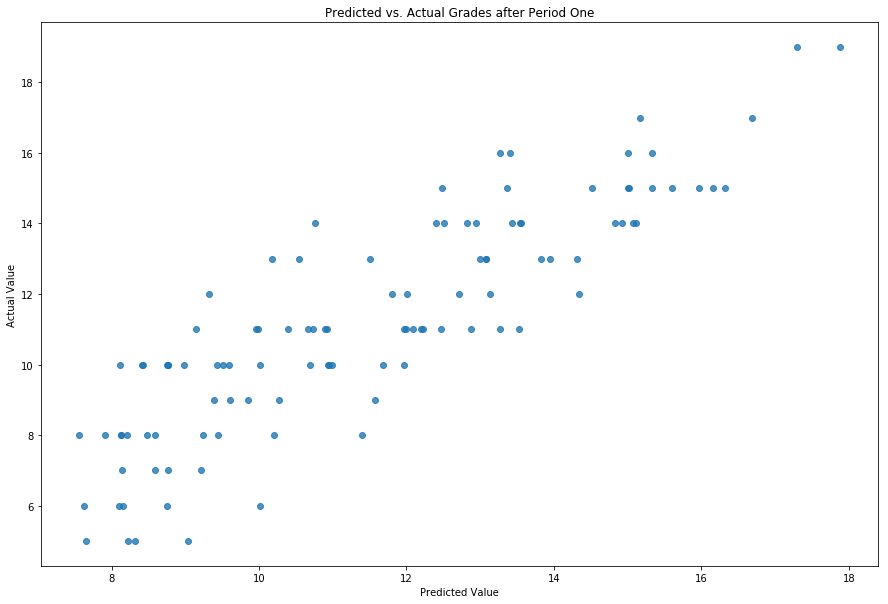

In [28]:
fig = plt.figure(figsize=(15,10))
plt.scatter(x1_axis, y_axis, alpha=0.8)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Predicted vs. Actual Grades after Period One')
plt.show()

In [29]:
X2 = df.drop(['G3', 'passed'], axis=1).values
y = df.G3.values
print(X.shape, y.shape)

(357, 30) (357,)


In [30]:
# Setup the pipeline steps: steps
steps = [('ohe', OneHotEncoder(categories=categories2)),
         ('rfr', RandomForestRegressor(max_depth=20, criterion='mse'))]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'rfr__n_estimators': np.arange(150, 250, 10)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=0)

# Create the GridSearchCV object: yeg_cv
second_predict_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_mean_squared_error', cv=10, iid=False)

# Fit to the training set
second_predict_cv.fit(X_train, y_train)

# Compute and print the metrics
mse = second_predict_cv.score(X_test, y_test)
print("Tuned RandomForest estimators: {}".format(second_predict_cv.best_params_))
print("Tuned RandomForest mean squared error: {}".format(mse))
print(np.sqrt(abs(mse)))

Tuned RandomForest estimators: {'rfr__n_estimators': 230}
Tuned RandomForest mean squared error: -0.986180188167013
0.9930660542818958


In [31]:
x1_axis = second_predict_cv.predict(X_test)
y_axis = y_test

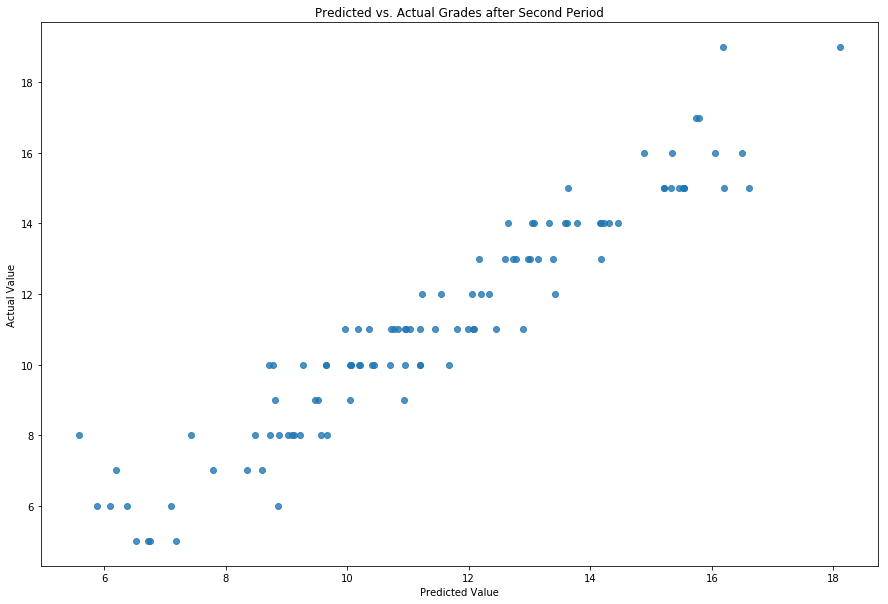

In [32]:
fig = plt.figure(figsize=(15,10))
plt.scatter(x1_axis, y_axis, alpha=0.8)
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')
plt.title('Predicted vs. Actual Grades after Second Period')
plt.show()

# Ordinal Logistic Regression

In [33]:
from mord import LogisticIT

In [34]:
# Setup the pipeline steps: steps
steps = [('ohe', OneHotEncoder(categories=categories)),
         ('lit', LogisticIT())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'lit__alpha': np.arange(0, 5, 0.1)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Create the GridSearchCV object: yeg_cv
pass_predict_cv = GridSearchCV(pipeline, param_grid=parameters, scoring='neg_mean_squared_error', cv=10, iid=False)

# Fit to the training set
pass_predict_cv.fit(X_train, y_train)

# Compute and print the metrics
mse = pass_predict_cv.score(X_test, y_test)
print("Tuned LogisticIT estimators: {}".format(pass_predict_cv.best_params_))
print("Tuned LogisticIT mean squared error: {}".format(mse))
print(np.sqrt(abs(mse)))

Tuned LogisticIT estimators: {'lit__alpha': 4.800000000000001}
Tuned LogisticIT mean squared error: -11.88888888888889
3.4480268109295333


In [35]:
feat_logit = pass_predict_cv.best_estimator_.named_steps.lit.coef_
feat_odds = np.exp(feat_logit[0])
feat_columns = pass_predict_cv.best_estimator_.named_steps.ohe.get_feature_names()
feat_zip = zip(feat_odds, feat_columns)
feat_list = list(feat_zip)
feat_list.sort(reverse=True)
print('Top Five Feature Odds:\n\n', 
      feat_list[:5], 
      '\n\n\n')
print('Encoded Variable Reference (x14_0 = first category of enumerated column 14 [failures] below):\n\n', 
      dict(enumerate(df.drop(['G1', 'G2', 'G3', 'improved', 'passed'], axis=1).columns)))

TypeError: zip argument #1 must support iteration